## Initialization

In [4]:
# import matplotlib.pyplot as plt
import pickle
import torch
import torchviz
from CST2 import *
device = torch.device('cuda') # 'cpu', 'cuda', 'mps' ...

In [2]:
torch.__version__

'2.0.0+cu117'

## Testing

### Transformer

#### Test 1: Log Probability Estimation


**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

In [3]:
tf = Transformer(outtk_size=2)
tf.eval()
x = torch.tensor([[4],[4],[5],[5],[6],[6]])

In [4]:
y, logprob = tf.sample(x, 1, need_logprob=True)
y, logprob

(tensor([[1],
         [2],
         [2],
         [1],
         [2],
         [1]]),
 tensor([-1.2067, -0.3555, -0.4196, -1.0710, -0.2479, -1.5162]))

In [5]:
tf.logprob(x, y)

tensor([-1.2067, -0.3555, -0.4196, -1.0710, -0.2479, -1.5162],
       grad_fn=<SumBackward1>)

#### Test 2: Generative Modeling
**Goal:** test the ability of the transformer model to learn sequence-to-sequence map.

In [6]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])


optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss = -tf.logprob(x, y).mean()
    loss.backward()
    optimizer.step()
    print('{:3d}: {:8.5g}'.format(epoch, loss.item()))

  0:  0.66656
  1:  0.61889
  2:  0.56802
  3:  0.52628
  4:  0.52041
  5:  0.50918
  6:  0.47761
  7:   0.4881
  8:  0.48566
  9:  0.47733


Learns to predict $y$ from $x$.

In [7]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9901126027107239,
 0.009887431748211384,
 0.5010855197906494,
 0.4989144802093506,
 0.36346420645713806,
 0.6365358233451843,
 0.6365358233451843]

#### Test 3: VAE loss
**Goal**: test training the transformer with VAE bottleneck

In [8]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss, logprob, kld = tf.loss(x, y, beta=0.)
    loss.backward()
    optimizer.step()
    print(f'{epoch:3d}: {loss.item():8.5g} {logprob.item():8.5g} {kld.item():8.5g}')


  0:  0.79492 -0.79492   1.0095
  1:  0.64108 -0.64108   1.0168
  2:  0.65787 -0.65787   1.0297
  3:  0.66132 -0.66132   1.0396
  4:  0.60954 -0.60954   1.0463
  5:  0.55747 -0.55747   1.0657
  6:  0.55708 -0.55708   1.0634
  7:  0.61399 -0.61399    1.077
  8:  0.61382 -0.61382   1.0781
  9:  0.48002 -0.48002   1.0889


Learns to predict $y$ from $x$.
Now the accuracy can be controlled by the hyperparameter $\beta$.

In [9]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9304821491241455,
 0.06951788067817688,
 0.5117765665054321,
 0.48822343349456787,
 0.3198130428791046,
 0.680186927318573,
 0.680186927318573]

#### Test 4: Sampling
**Goal**: test sampling and completion.

In [10]:
tf = Transformer(outtk_size=2)
x = torch.randint(4,7,(3,5))
print(tf.sample(x))

tensor([[2, 1, 2, 2],
        [2, 1, 2, 1],
        [2, 1, 2, 1]])


Completion task.

In [11]:
y = torch.randint(1,3,(3,2))
print(y)
print(tf.sample(x, tgt_seq=y))

tensor([[2, 1],
        [2, 1],
        [1, 1]])
tensor([[2, 1, 2, 1],
        [2, 1, 2, 1],
        [1, 1, 2, 1]])


### Operator

#### Test 1: Operator Algebra

In [12]:
ops = [pauli([i]) for i in range(4)]
ops

[I, X, Y, Z]

Multiplication table of Pauli operators

In [13]:
for op1 in ops: 
    for op2 in ops:
        print(f'{op1} @ {op2} = {op1 @ op2}')

I @ I = I
I @ X = X
I @ Y = Y
I @ Z = Z
X @ I = X
X @ X = I
X @ Y = i Z
X @ Z = -i Y
Y @ I = Y
Y @ X = -i Z
Y @ Y = I
Y @ Z = i X
Z @ I = Z
Z @ X = i Y
Z @ Y = -i X
Z @ Z = I


#### Test 2: Operator Gradient

In [14]:
O = pauli('X') + 1j * pauli('Y') - 2 * pauli('Z')
O

X + i Y -2 Z

### Shdaow

#### Test 1: Shadow Evaluate 
**Goal:** evaluate operator expectation value on a shadow dataset.

In [15]:
n_qubit=6
rho = w_state(n_qubit)
sigma = shadow(n_qubit,1)

print(rho,'\n',sigma)

(Statevector([-3.27086160e-17+0.j,  4.08248290e-01+0.j,  4.08248290e-01+0.j,
             -3.27086160e-17+0.j,  4.08248290e-01+0.j, -2.86969078e-18+0.j,
              1.13057994e-17+0.j, -2.45535451e-35+0.j,  4.08248290e-01+0.j,
             -2.86969078e-18+0.j,  1.13057994e-17+0.j, -2.45535451e-35+0.j,
             -1.16876723e-17+0.j, -1.85084471e-34+0.j, -8.06692507e-35+0.j,
              3.04726830e-51+0.j,  4.08248290e-01+0.j,  8.62704507e-18+0.j,
             -1.90936457e-19+0.j, -1.74001567e-34+0.j,  4.57116746e-18+0.j,
             -5.72070107e-18+0.j,  1.24765000e-34+0.j,  9.77601859e-34+0.j,
              4.85855828e-17+0.j, -1.38777878e-17+0.j, -1.38777878e-17+0.j,
             -8.33757172e-34+0.j, -8.12941988e-18+0.j,  2.07155257e-34+0.j,
              1.43000908e-33+0.j,  4.67308965e-35+0.j,  4.08248290e-01+0.j,
             -1.43664266e-17+0.j, -4.95304037e-18+0.j, -6.45477501e-34+0.j,
             -1.90936457e-19+0.j,  1.17087743e-17+0.j, -1.74305608e-34+0.j,
           

### ClassicalShdow Transformer

#### Test 1: Sampling

**Goal**: test sampling and state reconstruction

In [16]:
cst = ClassicalShadowTransformer(2,0,state_name='w_state')


Reconstruct density operator (matrix).

In [17]:
rho = cst.rho()
print(rho,"\n")
rhomat = rho.matrix_form() / 2**2
print(rhomat)

1.00 II -0.17 IX -0.31 IY -0.16 IZ + 0.53 XI -0.13 XX -0.18 XY -0.14 XZ + 0.44 YI -0.16 YX -0.18 YY -0.16 YZ + 0.57 ZI -0.10 ZX -0.15 ZY -0.07 ZZ (grad_fn=<class 'SqueezeBackward4'>) 

tensor([[ 0.3346+0.0000j, -0.0671+0.1166j,  0.0969-0.0701j,  0.0135+0.0844j],
        [-0.0671-0.1166j,  0.4500+0.0000j, -0.0783-0.0063j,  0.1674-0.1498j],
        [ 0.0969+0.0701j, -0.0783+0.0063j,  0.0847+0.0000j, -0.0166+0.0399j],
        [ 0.0135-0.0844j,  0.1674+0.1498j, -0.0166-0.0399j,  0.1307+0.0000j]],
       grad_fn=<DivBackward0>)


In [18]:
torch.linalg.eigvalsh(rhomat)

tensor([0.0076, 0.0411, 0.2744, 0.6768], grad_fn=<LinalgEighBackward0>)

## Trainning

### Batch Trainning

Scaning over parameter space and train a collection of models of different number of qubits and hyperparameter $\beta$. <br>
`max_steps` - maximal optimization step, <br>
`nsr` - the noise signal ratio threshold for the loss function flucturation (optimization stop when the noise signal ratio is larger than this threshold), <br>
`window` - the window size used to estimate noise signal ratio (larger window size stricter convergence criterion), <br>
`n_sample` - number of classical shadow samples used in each iteration, <br>
`lr` -  learning rate.<br>
`state_name` - certain state you want to generate and be trainned

#### Sample data

In [130]:
for n_qubit in range(1,7):
    cst = ClassicalShadowTransformer(n_qubit, logbeta=1,state_name='GHZ').to(device).load()
    cst.sample(n_sample=400,sample_size=200)

In [49]:
for n_qubit in range(1,7):
    cst = ClassicalShadowTransformer(n_qubit, logbeta=1,state_name='W_state').to(device).load()
    cst.sample(n_sample=400,sample_size=200)

In [50]:
for n_qubit in range(1,7):
    cst = ClassicalShadowTransformer(n_qubit, logbeta=1,state_name='Zero_state').to(device).load()
    cst.sample(n_sample=400,sample_size=200)

#### Train the model

In [53]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta,embed_dim=64,state_name='GHZ').to(device).load()
        cst.optimize(steps=400, max_steps=600, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d64_h16_l1/GHZ_N5_b6
599:  3.87512 -3.42053  0.00710 -0.00001


In [51]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta,embed_dim=64,state_name='W_state').to(device).load()
        cst.optimize(steps=200, max_steps=400, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d64_h16_l1/W_state_N5_b6
399:  3.84536 -3.32758  0.00809 -0.00007


In [112]:
for n_qubit in range(1,6):
    for logbeta in range(-6,7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta,embed_dim=64,state_name='Zero_state').to(device).load()
        cst.optimize(steps=400, max_steps=600, nsr=32, window=100, n_sample=400, lr=0.00001)

./model/CST_d64_h16_l1/Zero_state_N5_b6
399:  3.70496 -3.17016  0.00836 -0.00048


#### Test 1: Log Probability Estimation


**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

scan over the number of qubits and dimensionality of embeded space,selcet log $\beta$  =1

In [37]:
for n_qubit in range(1,7):
    for dim in [256,128,64,32]:
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=1,state_name='GHZ',embed_dim=dim).to(device).load()
        cst.optimize(200, max_steps=500, nsr=32, window=100, n_sample=200, lr=0.0001)

./model/CST_d32_h16_l1/GHZ_N6_b1
499:  4.15750 -4.09434  0.03158 -0.00465


In [53]:
for n_qubit in range(1,7):
   for dim in [256,128,64,32]: 
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=1,state_name='Zero_state',embed_dim=dim).to(device).load()
        cst.optimize(200, max_steps=500, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/Zero_state_N6_b1
203:  3.81377 -3.73732  0.03822 -0.01801


In [54]:
for n_qubit in range(1,7):
    for dim in [256,128,64,32]:
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=1,state_name='W_state',embed_dim=dim).to(device).load()
        cst.optimize(200, max_steps=1000, nsr=32, window=100, n_sample=400, lr=0.0001)

./model/CST_d32_h16_l1/W_state_N6_b1
206:  4.01890 -3.96744  0.02573 -0.00906


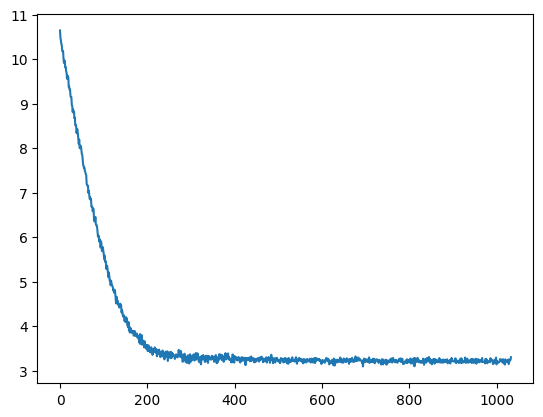

In [119]:
import matplotlib.pyplot as plt
cst = ClassicalShadowTransformer(5,logbeta=3,state_name='Zero_state').load()
#print(cst.transformer.repara.logvar)
plt.plot(cst.loss_history[10:])

### Fine Tunning

If necessary, a model can be loaded for fine tuning with smaller training rate to ensure convergence.

In [ ]:
cst = ClassicalShadowTransformer(5, -6).load()
cst.optimize(100, max_steps=1000, nsr=32, window=1000, n_sample=1000, lr=0.00001)

## Evaluation

### Loss Function Hostory

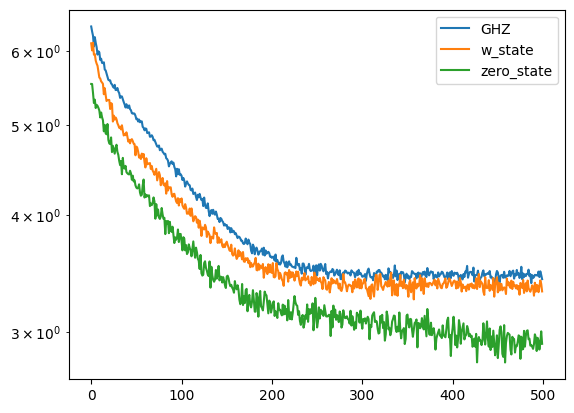

In [124]:
state=['GHZ','w_state','zero_state']
for s in state:
    logbeta=1
    cst = ClassicalShadowTransformer(5,logbeta,s,embed_dim=64).load()
    plt.plot(cst.loss_history[0:500],label=s)

# Add a legend to the plot
plt.legend()
plt.yscale( "log")
# Show the plot
plt.show()
    

### Fidelity and Entropy Map
Compute `fidelity` and `entropy `(in unit of bit) of the reconstructed density matrix.

using `map.data`

#### over n-qubits nad dimensionality, log $\beta$ =1

In [61]:
data = []
for n_qubit in range(1,6):
    for dim in [256,128,64,32]:
        cst = ClassicalShadowTransformer(n_qubit=n_qubit, logbeta=1,state_name='W_state',embed_dim=dim).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
        fid = fid.real.item()
        vals = torch.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -torch.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, dim, fid, ent])

./model/CST_d32_h16_l1/W_state_N5_b1
F = 0.08527898788452148, S = 3.869696617126465


In [164]:
state=zero_state(5)[0]
state.is_valid()

True

In [166]:
rho.is_valid()

True

In [171]:
obs = torch.cartesian_prod(*([torch.arange(1, 4)]*5)).view(-1, 5)
out = torch.cartesian_prod(*([torch.arange(2)]*5)).view(-1, 5)
n_obs, n_out = obs.shape[0], out.shape[0]
print(n_obs,n_out)

243 32


In [165]:
from qiskit.quantum_info import DensityMatrix,state_fidelity
cst = ClassicalShadowTransformer(n_qubit=5, logbeta=1,state_name='GHZ',embed_dim=64).load().eval()
rho = cst.rho().matrix_form()/2**cst.n_qubit
fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
rho=rho.detach().numpy()
ghz=ghz_state(5)
rho_ghz=DensityMatrix(ghz[0])
rho=DensityMatrix(rho)
print(rho_ghz,'\n',rho)
# fid_0=state_fidelity(rho,rho_ghz)
# print(fid,fid_0)


DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               ...,
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2, 2, 2, 2)) 
 DensityMatrix([[ 7.10409805e-02+0.00000000e+00j,
                 1.78409144e-02-1.78947914e-02j,
                 1.73036158e-02-1.73748378e-02j, ...,
                -3.46924481e-03+6.09905692e-06j,
                -3.21090547e-03+1.44297956e-05j,
                -1.41558703e-05+9.40356404e-06j],
               [ 1.78409144e-02+1.78947914e-02j,
                 3.47741134e-02+0.00000000e+00j,
                 1.19762290e-02+1.15833245e-07j, ...,
                 7.69152539e-05+6

In [136]:
import qutip as qs
qs.fidelity()

d:\programing\Anaconda\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


##### `Zero_state`

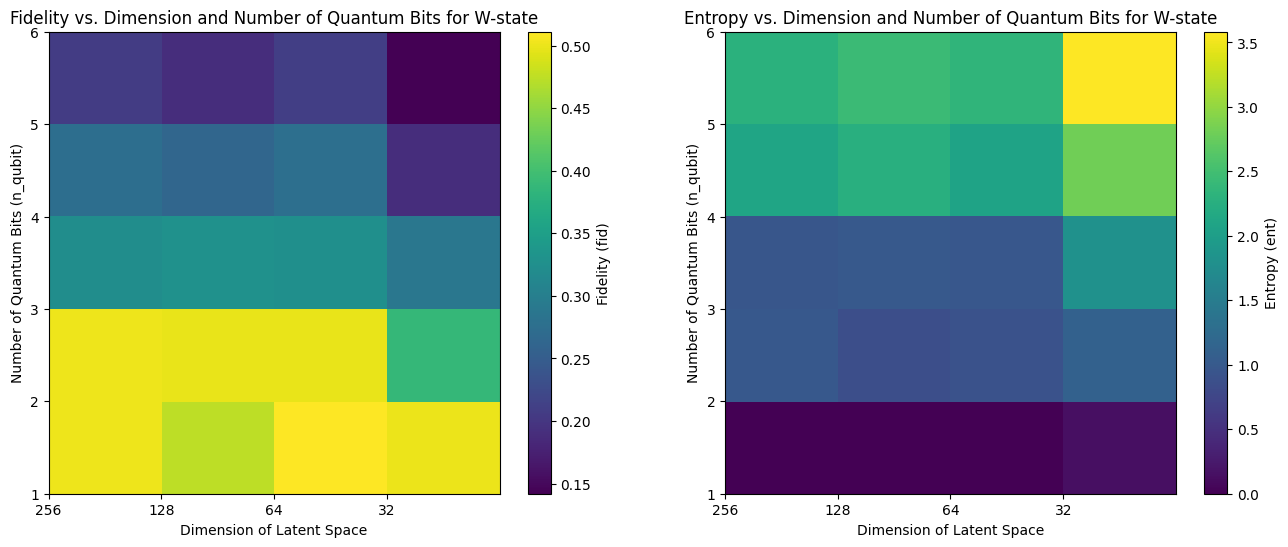

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta、保真度和熵列
n_qubit = data_array[:, 0]
dim = data_array[:, 1]
fid = data_array[:, 2]
ent = data_array[:, 3]
fid_matrix = np.zeros((5, 4))
ent_matrix = np.zeros((5, 4))
dim_values = [256, 128, 64, 32]  # 定义维度取值

# 创建一个矩阵，将 fid 和 ent 值填充到相应的位置
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
    fid_matrix[n, d] = fid[i]
    ent_matrix[n, d] = ent[i]

# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制 Fidelity 矩阵
fid_img = axes[0].imshow(fid_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[0].set_xticks(np.arange(len(dim_values)))
axes[0].set_xticklabels(dim_values)
axes[0].set_xlabel('Dimension of Latent Space')
axes[0].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[0].set_title('Fidelity vs. Dimension and Number of Quantum Bits for W-state')
plt.colorbar(fid_img, ax=axes[0], label='Fidelity (fid)')  # 添加颜色条

# 绘制 Entropy 矩阵
ent_img = axes[1].imshow(ent_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[1].set_xticks(np.arange(len(dim_values)))
axes[1].set_xticklabels(dim_values)
axes[1].set_xlabel('Dimension of Latent Space')
axes[1].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[1].set_title('Entropy vs. Dimension and Number of Quantum Bits for W-state')
plt.colorbar(ent_img, ax=axes[1], label='Entropy (ent)')  # 添加颜色条

plt.show()


##### `w_state`

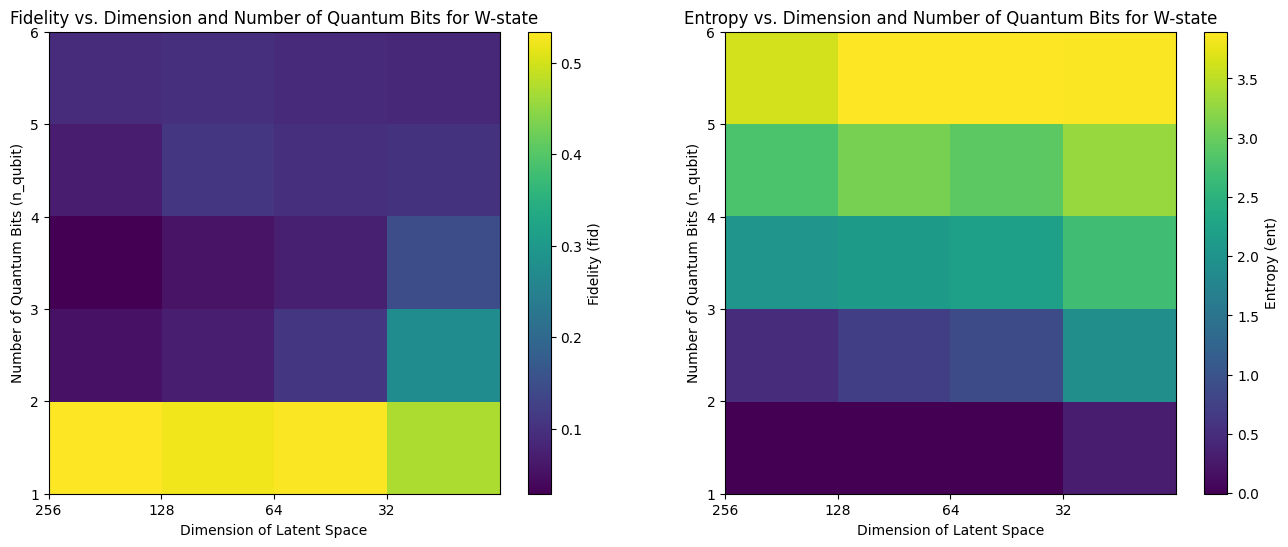

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta、保真度和熵列
n_qubit = data_array[:, 0]
dim = data_array[:, 1]
fid = data_array[:, 2]
ent = data_array[:, 3]
fid_matrix = np.zeros((5, 4))
ent_matrix = np.zeros((5, 4))
dim_values = [256, 128, 64, 32]  # 定义维度取值

# 创建一个矩阵，将 fid 和 ent 值填充到相应的位置
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
    fid_matrix[n, d] = fid[i]
    ent_matrix[n, d] = ent[i]

# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制 Fidelity 矩阵
fid_img = axes[0].imshow(fid_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[0].set_xticks(np.arange(len(dim_values)))
axes[0].set_xticklabels(dim_values)
axes[0].set_xlabel('Dimension of Latent Space')
axes[0].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[0].set_title('Fidelity vs. Dimension and Number of Quantum Bits for W-state')
plt.colorbar(fid_img, ax=axes[0], label='Fidelity (fid)')  # 添加颜色条

# 绘制 Entropy 矩阵
ent_img = axes[1].imshow(ent_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[1].set_xticks(np.arange(len(dim_values)))
axes[1].set_xticklabels(dim_values)
axes[1].set_xlabel('Dimension of Latent Space')
axes[1].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[1].set_title('Entropy vs. Dimension and Number of Quantum Bits for W-state')
plt.colorbar(ent_img, ax=axes[1], label='Entropy (ent)')  # 添加颜色条

plt.show()


##### `GHZ`

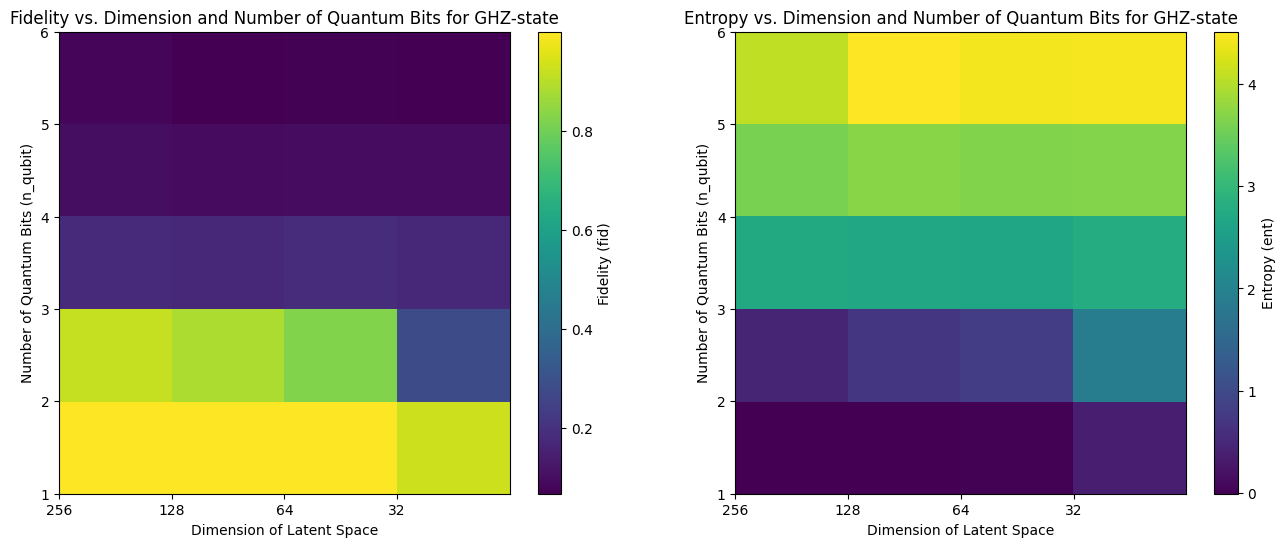

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta、保真度和熵列
n_qubit = data_array[:, 0]
dim = data_array[:, 1]
fid = data_array[:, 2]
ent = data_array[:, 3]
fid_matrix = np.zeros((5, 4))
ent_matrix = np.zeros((5, 4))
dim_values = [256, 128, 64, 32]  # 定义维度取值

# 创建一个矩阵，将 fid 和 ent 值填充到相应的位置
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    d = dim_values.index(int(dim[i]))  # 获取维度在取值列表中的索引
    fid_matrix[n, d] = fid[i]
    ent_matrix[n, d] = ent[i]

# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制 Fidelity 矩阵
fid_img = axes[0].imshow(fid_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[0].set_xticks(np.arange(len(dim_values)))
axes[0].set_xticklabels(dim_values)
axes[0].set_xlabel('Dimension of Latent Space')
axes[0].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[0].set_title('Fidelity vs. Dimension and Number of Quantum Bits for GHZ-state')
plt.colorbar(fid_img, ax=axes[0], label='Fidelity (fid)')  # 添加颜色条

# 绘制 Entropy 矩阵
ent_img = axes[1].imshow(ent_matrix, cmap='viridis', extent=[0, len(dim_values), 1, 6], aspect='auto', origin='lower')
axes[1].set_xticks(np.arange(len(dim_values)))
axes[1].set_xticklabels(dim_values)
axes[1].set_xlabel('Dimension of Latent Space')
axes[1].set_ylabel('Number of Quantum Bits (n_qubit)')
axes[1].set_title('Entropy vs. Dimension and Number of Quantum Bits for GHZ-state')
plt.colorbar(ent_img, ax=axes[1], label='Entropy (ent)')  # 添加颜色条

plt.show()


#### over `log` $\beta$  and `n-qubits`, `dim`=64

In [122]:
data = []
for n_qubit in range(1, 6):
    for logbeta in range(-6, 7):
        cst = ClassicalShadowTransformer(n_qubit,logbeta,'Zero_state',embed_dim=64).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form()/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
        fid = fid.real.item()
        vals = torch.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -torch.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])

./model/CST_d64_h16_l1/Zero_state_N5_b6
F = 0.07393719255924225, S = 3.687603235244751


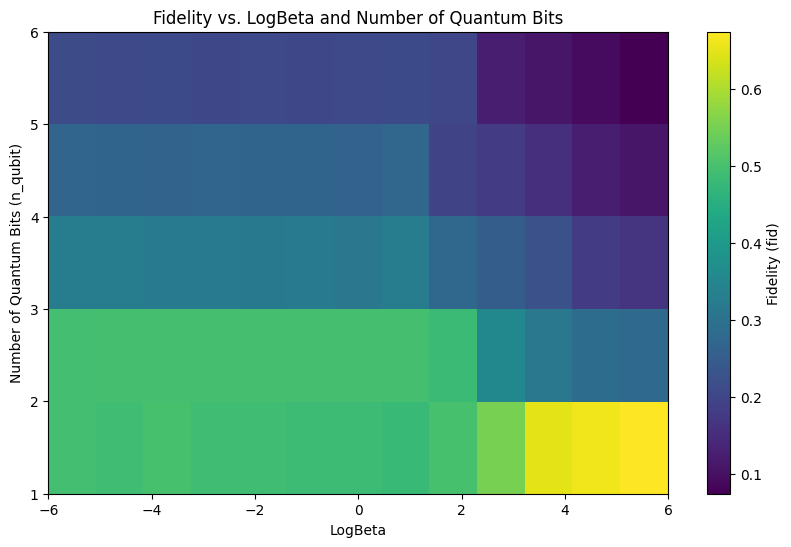

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta 和保真度列
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
fid = data_array[:, 2]
fid_matrix=np.zeros((5,13))
# 创建一个矩阵，将 fid 值填充到相应的位置
entropy = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    fid_matrix[n, lb] = fid[i]

# 创建热图，根据 entropy_matrix 中的值来着色
plt.figure(figsize=(10, 6))
plt.imshow(fid_matrix, cmap='viridis', extent=[-6, 6, 1, 6], aspect='auto', origin='lower')
plt.colorbar(label='Fidelity (fid)')
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('Fidelity vs. LogBeta and Number of Quantum Bits')

plt.show()


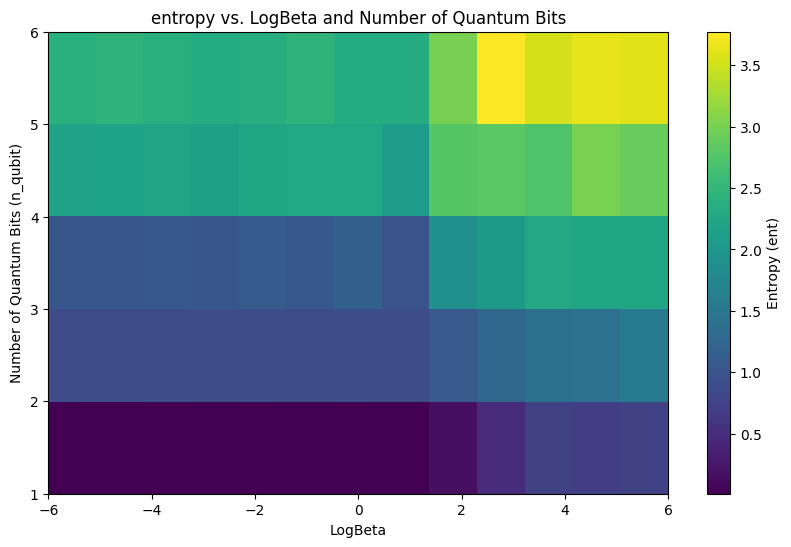

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# 从 data 列表中提取数据并转换为 NumPy 数组
data_array = np.array(data)

# 提取量子比特数、logbeta 和保真度列
n_qubit = data_array[:, 0]
logbeta = data_array[:, 1]
entropy = data_array[:, 3]

# 创建一个矩阵，将 fid 值填充到相应的位置
entropy_matrix = np.zeros((5, 13))  # 根据数据的范围创建一个矩阵
for i in range(len(data)):
    n = int(n_qubit[i] - 1)
    lb = int(logbeta[i] + 6)
    entropy_matrix[n, lb] = entropy[i]

# 创建热图，根据 entropy_matrix 中的值来着色
plt.figure(figsize=(10, 6))
plt.imshow(entropy_matrix, cmap='viridis', extent=[-6, 6, 1, 6], aspect='auto', origin='lower')
plt.colorbar(label='Entropy (ent)')
plt.xlabel('LogBeta')
plt.ylabel('Number of Quantum Bits (n_qubit)')
plt.title('entropy vs. LogBeta and Number of Quantum Bits')

plt.show()

###  Atlas Boreas Cygnus

Take three representative models.

In [101]:
state='GHZ'
mdls = {
    'atlas': ClassicalShadowTransformer(5, -5,state,embed_dim=64).load().eval(),
    'boreas': ClassicalShadowTransformer(5, -1,state,embed_dim=64).load().eval(),
    'cygnus': ClassicalShadowTransformer(5, 6,state,embed_dim=64).load().eval()}

Chat with the model. Dictionary:

| Number | Symbol |
|--------|--------|
| `1`    | `+`    |
| `2`    | `-`    |
| `3`    | `I`    |
| `4`    | `X`    |
| `5`    | `Y`    |
| `6`    | `Z`    |

* Z-test: `x: ZZZZZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* X-test: `x: XXXXX, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* XZ-test: `x: XXXXZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 

Collect data:

In [102]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0, torch.zeros(y0.shape[0], dtype=torch.long)[:, None]], 1)
x = torch.zeros_like(y) + 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/z_test.dat', 'wb') as f:
    pickle.dump(data, f)
print(x,'\n',y)

tensor([[6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6]]) 
 tensor([[1, 1, 1, 1, 0],
        [1, 1, 1, 2, 0],
        [1, 1, 2, 1, 0],
        [1, 1, 2, 2, 0],
        [1, 2, 1, 1, 0],
        [1, 2, 1, 2, 0],
        [1, 2, 2, 1, 0],
        [1, 2, 2, 2, 0],
        [2, 1, 1, 1, 0],
        [2, 1, 1, 2, 0],
        [2, 1, 2, 1, 0],
        [2, 1, 2, 2, 0],
        [2, 2, 1, 1, 0],
        [2, 2, 1, 2, 0],
        [2, 2, 2, 1, 0],
        [2, 2, 2, 2, 0]])


d:\programing\Anaconda\lib\site-packages\torch\nn\modules\activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(


In [103]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/x_test.dat', 'wb') as f:
    pickle.dump(data, f)
print(x,'\n',y)


tensor([[4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4]]) 
 tensor([[1, 1, 1, 1, 0],
        [1, 1, 1, 2, 0],
        [1, 1, 2, 1, 0],
        [1, 1, 2, 2, 0],
        [1, 2, 1, 1, 0],
        [1, 2, 1, 2, 0],
        [1, 2, 2, 1, 0],
        [1, 2, 2, 2, 0],
        [2, 1, 1, 1, 0],
        [2, 1, 1, 2, 0],
        [2, 1, 2, 1, 0],
        [2, 1, 2, 2, 0],
        [2, 2, 1, 1, 0],
        [2, 2, 1, 2, 0],
        [2, 2, 2, 1, 0],
        [2, 2, 2, 2, 0]])


In [104]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
x[:,-1] = 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/xz_test.dat', 'wb') as f:
    pickle.dump(data, f)
print(x,'\n',y)

tensor([[4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6],
        [4, 4, 4, 4, 6]]) 
 tensor([[1, 1, 1, 1, 0],
        [1, 1, 1, 2, 0],
        [1, 1, 2, 1, 0],
        [1, 1, 2, 2, 0],
        [1, 2, 1, 1, 0],
        [1, 2, 1, 2, 0],
        [1, 2, 2, 1, 0],
        [1, 2, 2, 2, 0],
        [2, 1, 1, 1, 0],
        [2, 1, 1, 2, 0],
        [2, 1, 2, 1, 0],
        [2, 1, 2, 2, 0],
        [2, 2, 1, 1, 0],
        [2, 2, 1, 2, 0],
        [2, 2, 2, 1, 0],
        [2, 2, 2, 2, 0]])


### Density Matrix Reconstruction

Reconstruct density matrices for representative models.

using `rhos.dat`

In [105]:
data = {}
for name, mdl in mdls.items():
    with torch.no_grad():
        rho = mdl.rho().matrix_form()/2**mdl.n_qubit # reconstruction
    data[name] = rho.tolist()
with open('./data/rhos.dat', 'wb') as f:
    pickle.dump(data, f)

### Latent Space Structure

`x` will be a tensor where each row is a unique combination of the numbers 4, 5, and 6 repeated 5 times. The total number of rows will be $3^5$ = 243, since there are 3 choices (4, 5, 6) for each of the 5 positions.

In [106]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
x = torch.cartesian_prod(*[torch.tensor([4,5,6])]*5)

data = {'x': (x-3).tolist()}
for name, mdl in mdls.items():
    with torch.no_grad():
        src = mdl.transformer.embed(x)
        mem = mdl.transformer.encode(src)
    mem = mem.view(mem.shape[0],-1)
    z = tsne.fit_transform(mem)
    # z = pca.fit_transform(mem.numpy())
    
    data[name] = z.tolist()
with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)

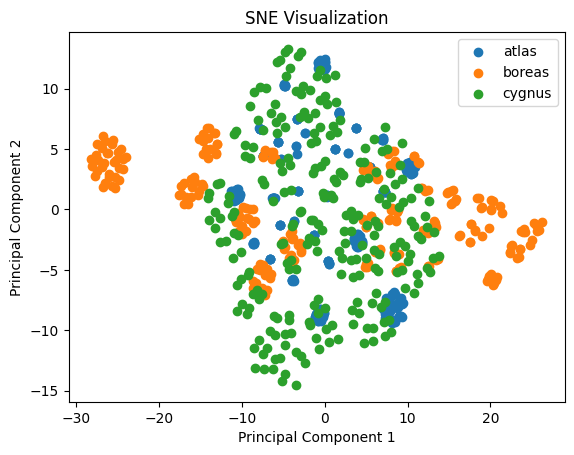

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


with open('./data/z_embed.dat', 'rb') as f:
    data = pickle.load(f)


x_data = data['x']
z_data = {name: data_point for name, data_point in data.items() if name != 'x'}


for name, z_points in z_data.items():
   
    z_points = np.array(z_points)
    plt.scatter(z_points[:, 0], z_points[:, 1], label=name)


plt.title('SNE Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


plt.legend()


plt.show()


In [108]:
data_x=data['x']
unique_sequences = set(tuple(row) for row in data_x)

# 获取不同数列的数量
num_unique_sequences = len(unique_sequences)

print(f"有 {num_unique_sequences} 种不同的数列。")

有 243 种不同的数列。


In [109]:
for item in data.items():
    print(item)

('x', [[1, 1, 1, 1, 1], [1, 1, 1, 1, 2], [1, 1, 1, 1, 3], [1, 1, 1, 2, 1], [1, 1, 1, 2, 2], [1, 1, 1, 2, 3], [1, 1, 1, 3, 1], [1, 1, 1, 3, 2], [1, 1, 1, 3, 3], [1, 1, 2, 1, 1], [1, 1, 2, 1, 2], [1, 1, 2, 1, 3], [1, 1, 2, 2, 1], [1, 1, 2, 2, 2], [1, 1, 2, 2, 3], [1, 1, 2, 3, 1], [1, 1, 2, 3, 2], [1, 1, 2, 3, 3], [1, 1, 3, 1, 1], [1, 1, 3, 1, 2], [1, 1, 3, 1, 3], [1, 1, 3, 2, 1], [1, 1, 3, 2, 2], [1, 1, 3, 2, 3], [1, 1, 3, 3, 1], [1, 1, 3, 3, 2], [1, 1, 3, 3, 3], [1, 2, 1, 1, 1], [1, 2, 1, 1, 2], [1, 2, 1, 1, 3], [1, 2, 1, 2, 1], [1, 2, 1, 2, 2], [1, 2, 1, 2, 3], [1, 2, 1, 3, 1], [1, 2, 1, 3, 2], [1, 2, 1, 3, 3], [1, 2, 2, 1, 1], [1, 2, 2, 1, 2], [1, 2, 2, 1, 3], [1, 2, 2, 2, 1], [1, 2, 2, 2, 2], [1, 2, 2, 2, 3], [1, 2, 2, 3, 1], [1, 2, 2, 3, 2], [1, 2, 2, 3, 3], [1, 2, 3, 1, 1], [1, 2, 3, 1, 2], [1, 2, 3, 1, 3], [1, 2, 3, 2, 1], [1, 2, 3, 2, 2], [1, 2, 3, 2, 3], [1, 2, 3, 3, 1], [1, 2, 3, 3, 2], [1, 2, 3, 3, 3], [1, 3, 1, 1, 1], [1, 3, 1, 1, 2], [1, 3, 1, 1, 3], [1, 3, 1, 2, 1], [1, 3, 

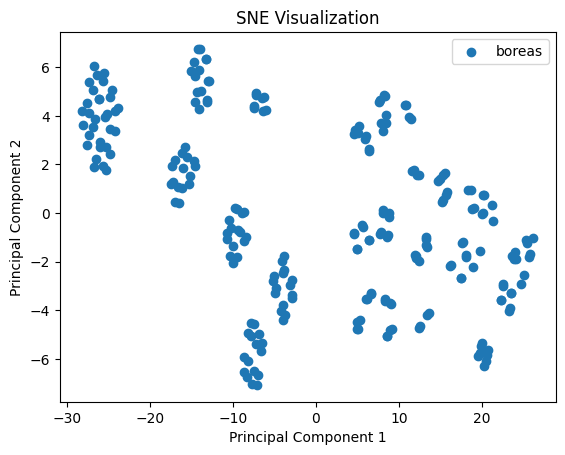

In [110]:
with open('./data/z_embed.dat', 'rb') as f:
    data = pickle.load(f)

# 你关注的名字
selected_names = ['boreas']
# 'atlas', 'boreas', 'cygnus'
# 提取 z_data
z_data = {name: data_point for name, data_point in data.items() if name in selected_names}

# 绘制散点图
for name, z_points in z_data.items():
    z_points = np.array(z_points)
    plt.scatter(z_points[:, 0], z_points[:, 1], label=name)

# 设置图表标题和坐标轴标签
plt.title('SNE Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 显示图例
plt.legend()

# 显示图表
plt.show()

##### test count

In [111]:
ztest

{'obs': [[1, 1, 1, 1],
  [1, 1, 1, 2],
  [1, 1, 2, 1],
  [1, 1, 2, 2],
  [1, 2, 1, 1],
  [1, 2, 1, 2],
  [1, 2, 2, 1],
  [1, 2, 2, 2],
  [2, 1, 1, 1],
  [2, 1, 1, 2],
  [2, 1, 2, 1],
  [2, 1, 2, 2],
  [2, 2, 1, 1],
  [2, 2, 1, 2],
  [2, 2, 2, 1],
  [2, 2, 2, 2]],
 'atlas': [[0.7628740668296814, -0.7176400423049927],
  [1.0752456188201904, -0.7750107049942017],
  [0.5016649961471558, -0.5707825422286987],
  [0.931786060333252, -0.7352085113525391],
  [0.50992751121521, -0.5634388327598572],
  [0.9535987973213196, -0.7297478914260864],
  [0.38511794805526733, -0.5248340368270874],
  [0.8597291111946106, -0.7121902108192444],
  [0.5424849987030029, -0.5883551836013794],
  [0.978400468826294, -0.7537215948104858],
  [0.41042423248291016, -0.5151364803314209],
  [0.8776904344558716, -0.7170294523239136],
  [0.4104892909526825, -0.5169785618782043],
  [0.8930819034576416, -0.7095203399658203],
  [0.32594630122184753, -0.4865816831588745],
  [0.8365088701248169, -0.6901025176048279]],
 'borea

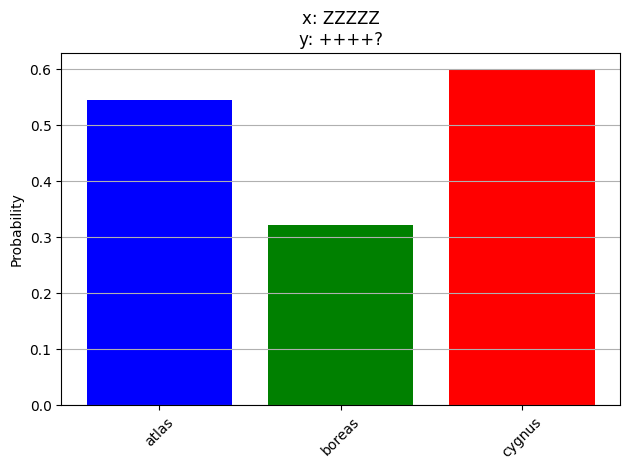

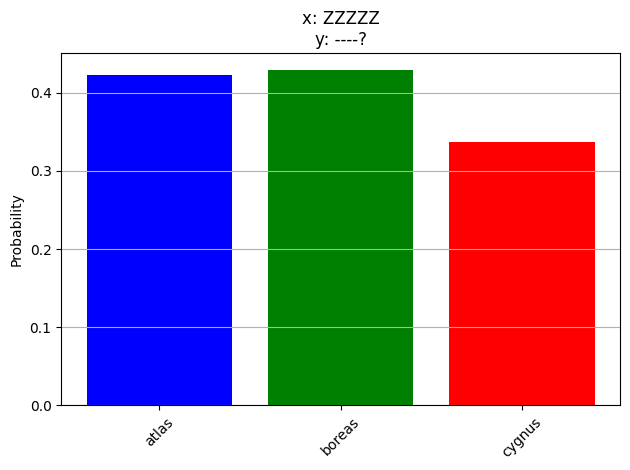

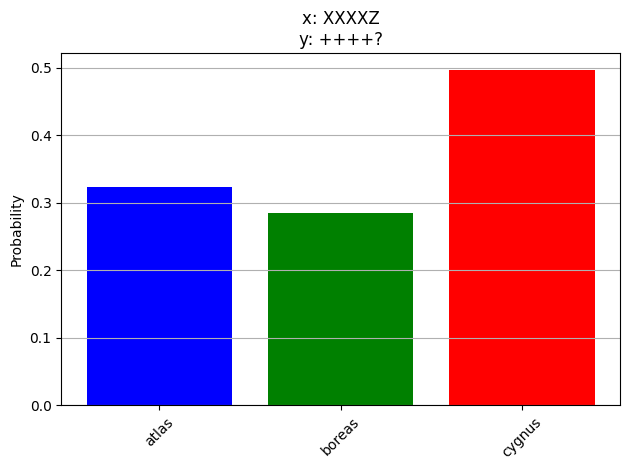

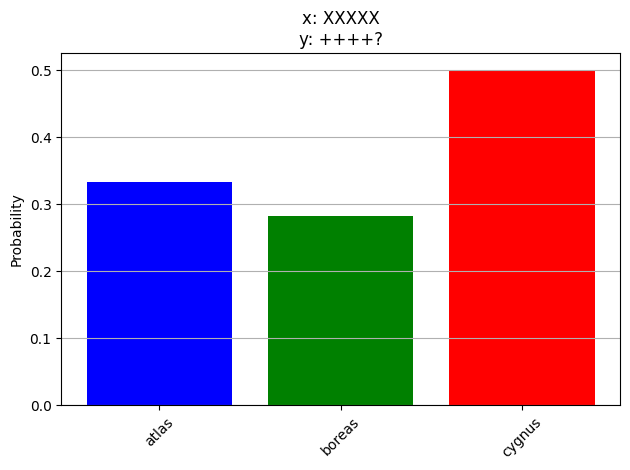

In [112]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data
notebook_directory = './'  # Replace with your notebook directory path
ztest = pickle.load(open(os.path.join(notebook_directory, 'data/z_test.dat'), 'rb'))
xtest = pickle.load(open(os.path.join(notebook_directory, 'data/x_test.dat'), 'rb'))
xztest = pickle.load(open(os.path.join(notebook_directory, 'data/xz_test.dat'), 'rb'))

# Model names
mdls = ["atlas", "boreas", "cygnus"]

# Function to create bar chart
def chart(test, v, prompt):
    ind = np.where(np.array(test["obs"]) == v)[0][0]
    logit = np.array([test[mdl][ind] for mdl in mdls])
    
    # Adjust the calculation of probabilities if necessary
    probabilities = np.exp(logit - np.max(logit))  # Subtracting the max for numerical stability
    probabilities = probabilities / probabilities.sum(axis=0)

    fig, ax = plt.subplots()
    for i, mdl in enumerate(mdls):
        ax.bar(mdl, probabilities[i], color=['blue', 'green', 'red'][i])
    
    ax.set_title(prompt, fontsize=12)
    ax.set_ylabel('Probability')
    ax.grid(True, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig, ax

# Now create and display charts
fig1, ax1 = chart(ztest, 1, "x: ZZZZZ\ny: ++++?")
fig2, ax2 = chart(ztest, 2, "x: ZZZZZ\ny: ----?")
fig3, ax3 = chart(xztest, 1, "x: XXXXZ\ny: ++++?")
fig4, ax4 = chart(xtest, 1, "x: XXXXX\ny: ++++?")

plt.show()


##### out-of distribution

In [115]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy.linalg import eigh
from scipy.linalg import sqrtm
from matplotlib.colors import LinearSegmentedColormap

# Load data
notebook_directory = './'  # Adjust as needed
z_test = pickle.load(open(os.path.join(notebook_directory, 'data/z_test.dat'), 'rb'))
x_test = pickle.load(open(os.path.join(notebook_directory, 'data/x_test.dat'), 'rb'))
xz_test = pickle.load(open(os.path.join(notebook_directory, 'data/xz_test.dat'), 'rb'))
rhos = pickle.load(open(os.path.join(notebook_directory, 'data/rhos.dat'), 'rb'))

mdls = list(rhos.keys())
col = {"atlas": "blue", "boreas": "green", "cygnus": "red"}
phase = {"atlas": "Quantum", "boreas": "Classical", "cygnus": "Thermal"}

# Define additional functions
def calculate_accuracy(test_data, model):
    # Placeholder for accuracy calculation - adjust as needed
    return np.mean(test_data[model])

def calculate_fidelity(rho):
    # Simplified fidelity calculation for rho with itself
    sqrt_rho = sqrtm(rho)
    product = np.dot(sqrt_rho, np.dot(rho, sqrt_rho))
    return np.trace(sqrtm(product))**2

def calculate_entropy(rho):
    eigenvalues, _ = eigh(rho)
    return -np.sum([p * np.log2(p) for p in eigenvalues if p > 0])

def make_colormap():
    # 创建一个颜色列表，从白色到'viridis'颜色映射的颜色
    colors = ['white'] + [plt.cm.viridis(i) for i in range(1, 256)]
    return colors.LinearSegmentedColormap.from_list("custom_viridis", colors, N=256)

# 使用自定义的颜色映射
custom_cmap = make_colormap()

for mdl in mdls:
    rho = rhos[mdl]

    # 计算指标
    zacc = calculate_accuracy(z_test, mdl)
    xacc = calculate_accuracy(x_test, mdl)
    fid = calculate_fidelity(rho)
    ent = calculate_entropy(rho)

    # 使用自定义颜色映射进行可视化
    plt.imshow(np.abs(rho), cmap=custom_cmap)
    plt.colorbar()
    plt.title(f"{phase[mdl]} - {mdl.capitalize()}\nZ-Accuracy: {zacc:.3f}, X-Accuracy: {xacc:.3f}, Fidelity: {fid:.3f}, Entropy: {ent:.3f}")
    plt.show()

AttributeError: 'list' object has no attribute 'LinearSegmentedColormap'

##### clustering figure

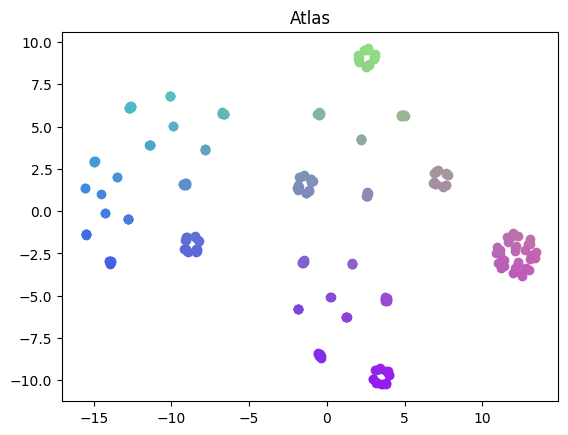

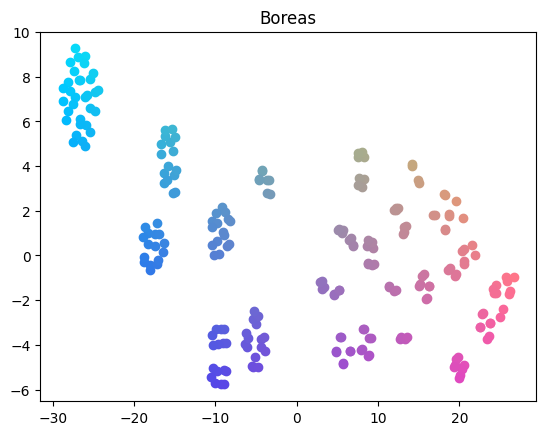

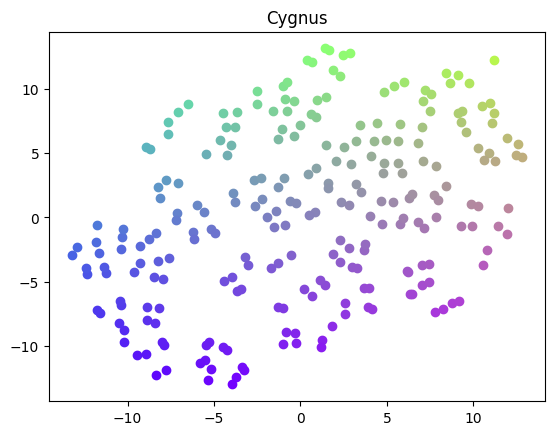

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba

# Load data
notebook_directory = './'  # Adjust as needed
data = pickle.load(open(os.path.join(notebook_directory, 'data/z_embed.dat'), 'rb'))

mdls = ["atlas", "boreas", "cygnus"]
def scheme_atlas(x):
    zloc = [i for i, v in enumerate(x) if v == 3]
    return zloc if zloc else x.count(1)

def scheme_boreas(x):
    return [i for i, v in enumerate(x) if v == 3]

def scheme_cygnus(x):
    return [x[0], x[-1]]

scheme = {
    "atlas": scheme_atlas,
    "boreas": scheme_boreas,
    "cygnus": scheme_cygnus
}

mark = {
    "atlas": [[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [1, 1, 2, 2, 2], [1, 1, 1, 2, 2], 
              [3, 1, 1, 1, 1], [1, 3, 3, 1, 1], [1, 3, 1, 3, 3], [3, 1, 3, 3, 3], 
              [3, 3, 3, 3, 3]],
    "boreas": [[1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [1, 1, 3, 1, 1], [1, 3, 1, 1, 1], 
               [1, 1, 3, 3, 1], [1, 3, 3, 1, 1], [3, 1, 1, 3, 3], [3, 1, 3, 3, 3], 
               [1, 3, 3, 3, 3], [3, 3, 3, 3, 3]],
    "cygnus": [[3, 2, 3, 1, 3], [3, 2, 2, 2, 3], [3, 3, 3, 3, 3], [1, 3, 3, 3, 2], 
               [1, 3, 2, 3, 2], [1, 2, 3, 2, 2]]
}


def colfunc(x, y):
    # Simple example: normalize x and y, then use them to create a color
    x_normalized = (x - min_x) / (max_x - min_x)
    y_normalized = (y - min_y) / (max_y - min_y)
    return (x_normalized, y_normalized, 1 - x_normalized * y_normalized)

# Assuming data[mdl] is a list of [x, y] points
all_points = [point for sublist in data.values() for point in sublist]
min_x, max_x = min(p[0] for p in all_points), max(p[0] for p in all_points)
min_y, max_y = min(p[1] for p in all_points), max(p[1] for p in all_points)

def visualize(mdl):
    for point in data[mdl]:
        plt.scatter(point[0], point[1], color=colfunc(point[0], point[1]))

for model in mdls:
    plt.figure()
    visualize(model)
    plt.title(model.capitalize())
    plt.show()


## trying

In [ ]:
from qiskit import QuantumRegister,QuantumCircuit, Aer, execute, transpile
from qiskit.quantum_info import Statevector
import numpy as np
import random
def ghz_state(n_qubit):
    """ Create a GHZ state for n_qubit qubits and return its state vector. """
    circuit = QuantumCircuit(n_qubit)
    circuit.h(0)
    for qubit in range(1, n_qubit):
        circuit.cx(0, qubit)
    return Statevector.from_instruction(circuit),circuit

def F_gate(circ, q, i, j, n, k):
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta, q[j])       
    circ.cz(q[i], q[j])
    circ.ry(theta, q[j])
    circ.barrier(q[i])

def cxrv(circ, q, i, j):
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j], q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i], q[j])

def w_state(n_qubit):
    q = QuantumRegister(n_qubit)
    W_states = QuantumCircuit(q)

    W_states.x(q[n_qubit-1])  # Start with the last qubit in state |1>

    # Apply F gates
    for i in range(n_qubit-1, 0, -1):
        F_gate(W_states, q, i, i-1, n_qubit, n_qubit-i)

    # Apply the controlled NOT gates
    for i in range(n_qubit-1, 0, -1):
        cxrv(W_states, q, i-1, i)
    return Statevector.from_instruction(W_states),W_states

def shadow(n_qubit, n_sample):
    """ Generate a list of random Pauli strings. """
    paulis = [ 'X', 'Y', 'Z']
    return [''.join(random.choice(paulis) for _ in range(n_qubit)) for _ in range(n_sample)]

def measure(state_vector, obs_list):
    """ Measure the given state vector with each observable in 'obs_list'. """
    results = []
    for obs in obs_list:
        n_qubit = len(obs)

        # Create a circuit from the state vector
        circuit = QuantumCircuit(n_qubit, n_qubit)  # add classical bits for measurement
        circuit.initialize(state_vector, range(n_qubit))  # initialize the state vector

        # Apply gates based on the observable
        for i, o in enumerate(obs):
            if o == 'X':
                circuit.h(i)
            elif o == 'Y':
                circuit.sdg(i)
                circuit.h(i)
        # Measure all qubits
        circuit.measure(range(n_qubit), range(n_qubit))

        # Execute the circuit
        backend = Aer.get_backend('qasm_simulator')
        transpiled_circuit = transpile(circuit, backend)
        job = execute(transpiled_circuit, backend, shots=1)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)
        # Extract the measurement result
        measurement_result = list(counts.keys())[0]
        results.append(measurement_result)

    return results
# Rest of your code (ghz_state, w_state, shadow) remains the same
def describe_statevector(statevector):
   
    if not isinstance(statevector, Statevector):
        raise ValueError("Input must be a Statevector.")

  
    num_qubits = int(np.log2(len(statevector)))

    # 描述态
    state_description = ""
    for i, amplitude in enumerate(statevector):
        if not np.isclose(amplitude, 0):
            # 将索引转换为二进制字符串
            binary_state = format(i, f'0{num_qubits}b')
            # 添加到描述
            if state_description != "":
                state_description += " + "
            state_description += f"({amplitude}) |{binary_state}⟩"

    return state_description





In [ ]:
# Example usage
n_qubit = 6
ghz,circuit_ghz = ghz_state(n_qubit)
w,circuit_w = w_state(n_qubit)

n_sample = 5
pauli_list = shadow(n_qubit, n_sample)

print(pauli_list)
measurement_ghz = measure(ghz, pauli_list)
measurement_w = measure(w, pauli_list)

print("Circuit for ghz:")
print(circuit_ghz.draw())
print("\nStatevector:")
print(describe_statevector(ghz))

print(f"GHZ Measurements: {measurement_ghz}")
print("Circuit for w:")
print(circuit_w.draw())
print("\nStatevector:")
print(describe_statevector(w))
print(f"W Measurements: {measurement_w}")

['ZXYYXZ', 'ZXZZZZ', 'YXZYXY', 'XYYYYY', 'ZXXYZX']
Circuit for ghz:
     ┌───┐                         
q_0: ┤ H ├──■────■────■────■────■──
     └───┘┌─┴─┐  │    │    │    │  
q_1: ─────┤ X ├──┼────┼────┼────┼──
          └───┘┌─┴─┐  │    │    │  
q_2: ──────────┤ X ├──┼────┼────┼──
               └───┘┌─┴─┐  │    │  
q_3: ───────────────┤ X ├──┼────┼──
                    └───┘┌─┴─┐  │  
q_4: ────────────────────┤ X ├──┼──
                         └───┘┌─┴─┐
q_5: ─────────────────────────┤ X ├
                              └───┘

Statevector:
((0.7071067811865475+0j)) |000000⟩ + ((0.7071067811865475+0j)) |111111⟩
GHZ Measurements: ['111111', '000000', '100110', '011101', '100100']
Circuit for w:
        ┌──────────┐                                                           »
q0_0: ──┤ Ry(-π/4) ├───────────────────────────────────────────────────────────»
      ┌─┴──────────┴─┐                                                         »
q0_1: ┤ Ry(-0.95532) ├─────────────────────────────

start W state 3-qubit on QasmSimulator('qasm_simulator') N= 1024 13/12/2023 13:55:20
end   W state 3-qubit on QasmSimulator('qasm_simulator') N= 1024 13/12/2023 13:55:20
start W state 4-qubit  QasmSimulator('qasm_simulator') N= 1024 13/12/2023 13:55:21
end   W state 4-qubit on QasmSimulator('qasm_simulator') N= 1024 13/12/2023 13:55:21
start W state 5-qubit on QasmSimulator('qasm_simulator') N= 1024 13/12/2023 13:55:21
end   W state 5-qubit on QasmSimulator('qasm_simulator') N= 1024 13/12/2023 13:55:21


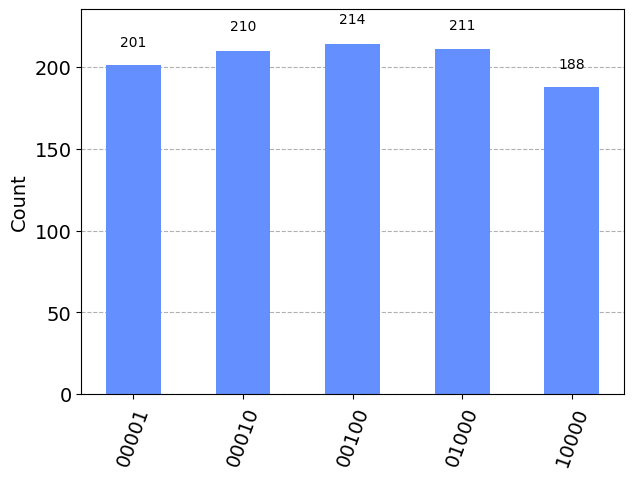

In [ ]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
from pprint import pprint

# importing Qiskit
from qiskit import Aer, IBMQ
# from qiskit.providers.ibmq import least_busy 
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram
flag_qx2 = True
backend = Aer.get_backend('qasm_simulator')  
if backend.name == 'ibmqx4':
    flag_qx2 = False
# Here, two useful routine
# Define a F_gate
def F_gate(circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
# Define the cxrv gate which uses reverse CNOT instead of CNOT
def  cxrv(circ,q,i,j) :
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j],q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i],q[j])
# 3-qubit W state
n = 3
q = QuantumRegister(n) 
c = ClassicalRegister(n)

W_states = QuantumCircuit(q,c) 

W_states.x(q[2]) #start is |100>
F_gate(W_states,q,2,1,3,1) # Applying F12
F_gate(W_states,q,1,0,3,2) # Applying F23

if flag_qx2 : # option ibmqx2 
    W_states.cx(q[1],q[2]) # cNOT 21
    W_states.cx(q[0],q[1]) # cNOT 32
    
else :        # option ibmqx4  
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)

for i in range(3) :
    W_states.measure(q[i] , c[i]) 

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3-qubit on', backend, "N=", shots,time_exp)
result = execute(W_states, backend=backend, shots=shots)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.result().get_counts(W_states))
# 4-qubit W state
n = 4
q = QuantumRegister(n) 
c = ClassicalRegister(n)
W_states = QuantumCircuit(q,c) 

W_states.x(q[3]) #start is |1000>
F_gate(W_states,q,3,2,4,1) # Applying F12
F_gate(W_states,q,2,1,4,2) # Applying F23
F_gate(W_states,q,1,0,4,3) # Applying F34        
cxrv(W_states,q,2,3) # cNOT 21
if flag_qx2 : # option ibmqx2  
    W_states.cx(q[1],q[2]) # cNOT 32
    W_states.cx(q[0],q[1]) # cNOT 43

else :        # option ibmqx4 
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)

for i in range(4) :
    W_states.measure(q[i] , c[i]) 

# circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 4-qubit ', backend, "N=", shots,time_exp)
result = execute(W_states, backend=backend, shots=shots)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 4-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.result().get_counts(W_states))
# 5-qubit W state
n = 5
q = QuantumRegister(n) 
c = ClassicalRegister(n)
W_states = QuantumCircuit(q,c) 

W_states.x(q[4]) #start is |10000>
F_gate(W_states,q,4,3,5,1) # Applying F12
F_gate(W_states,q,3,2,5,2) # Applying F23
F_gate(W_states,q,2,1,5,3) # Applying F34
F_gate(W_states,q,1,0,5,4) # Applying F45
W_states.cx(q[3],q[4]) # cNOT 21
cxrv(W_states,q,2,3)   # cNOT 32
if flag_qx2 : # option ibmqx2 
    W_states.cx(q[1],q[2]) # cNOT 43
    W_states.cx(q[0],q[1]) # cNOT 54
    
else :        # option ibmqx4 
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)     
    
for i in range(5) :
    W_states.measure(q[i] , c[i]) 

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 5-qubit on', backend, "N=", shots,time_exp)
result = execute(W_states, backend=backend, shots=shots)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 5-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.result().get_counts(W_states))

In [ ]:
# import matplotlib.pyplot as plt
import pickle
import torch
from CST2 import *
device = torch.device('cuda') # 'cpu', 'cuda', 'mps' ...
cst=ClassicalShadowTransformer(embed_dim=64,n_qubit=5,logbeta=1,state_name='W_state')



In [ ]:
with open('./data/z_test.dat', 'rb') as f:
    data=f.read()
    print(data)

b"\x80\x04\x95\x15\x05\x00\x00\x00\x00\x00\x00}\x94(\x8c\x03obs\x94]\x94(]\x94(K\x01K\x01K\x01K\x01e]\x94(K\x01K\x01K\x01K\x02e]\x94(K\x01K\x01K\x02K\x01e]\x94(K\x01K\x01K\x02K\x02e]\x94(K\x01K\x02K\x01K\x01e]\x94(K\x01K\x02K\x01K\x02e]\x94(K\x01K\x02K\x02K\x01e]\x94(K\x01K\x02K\x02K\x02e]\x94(K\x02K\x01K\x01K\x01e]\x94(K\x02K\x01K\x01K\x02e]\x94(K\x02K\x01K\x02K\x01e]\x94(K\x02K\x01K\x02K\x02e]\x94(K\x02K\x02K\x01K\x01e]\x94(K\x02K\x02K\x01K\x02e]\x94(K\x02K\x02K\x02K\x01e]\x94(K\x02K\x02K\x02K\x02ee\x8c\x05atlas\x94]\x94(]\x94(G?\xfa\xd5\x13\xe0\x00\x00\x00G\xc0\x01\x13t\xa0\x00\x00\x00e]\x94(G\xbf\xd9\xac\x0c \x00\x00\x00G?\xe3R\xaf@\x00\x00\x00e]\x94(G?\xf5\xaa\xd7 \x00\x00\x00G\xbf\xfc\x80\x96\xe0\x00\x00\x00e]\x94(G\xbf\xf3S\x88\x00\x00\x00\x00G?\xf7\xb1\xfd\xc0\x00\x00\x00e]\x94(G?\xf3\xff\n\xa0\x00\x00\x00G\xbf\xfa\xda0\x00\x00\x00\x00e]\x94(G\xbf\xf4\xc2h\x80\x00\x00\x00G?\xf8\xad\x06\x00\x00\x00\x00e]\x94(G?\xe7\xfd\xfd\x00\x00\x00\x00G\xbf\xf2\xab\x01 \x00\x00\x00e]\x94(G\xb

In [ ]:
print(cst.transformer)

Transformer(
  (token_embd): Embedding(7, 64)
  (posit_embd): Embedding(10, 64)
  (encode): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=256, out_features=64, bias=True)
        )
      )
    )
  )
  (repara): Randomizer()
  (decode): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((64,), eps=1e-05, elementw

In [ ]:
# import os


# graphviz_path = 'C:\\Program Files\\Graphviz\\bin' 
# os.environ["PATH"] += os.pathsep + graphviz_path

# from torchviz import make_dot
# cst=ClassicalShadowTransformer(n_qubit=5,logbeta=1,state_name='W_state')
# model=cst.transformer
# mock_src_seq = torch.randint(0, 6, (1, 3)) # 源序列
# mock_tgt_seq = torch.randint(0, 6, (1, 3)) # 目标序列
# model.eval()  # 设置模型为评估模式
# with torch.no_grad():  # 确保不计算梯度
#     mock_output = model(mock_src_seq, mock_tgt_seq)
# dot = make_dot(mock_output, params=dict(model.named_parameters()))

# # 显示图像
# dot.view()

